# CSC2042S 2025 
## Assignment 3 

## Optimization of a neural network for image classification 
#### Maryam Abrahams (ABRMAR043)
---

## Task 1: Data Processing

In [1]:

# Imports and setup 

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as random

from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Normalize, Compose
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Reproducibility setup

seed = 69
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)


In [2]:

#Defining the transformations
transform = Compose([
    ToTensor(),
    Normalize((0.5,), (0.5,))
])

# downloading all data
full_train_dataset = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

# validation, test and train splits

train_size = 50000
val_size = len(full_train_dataset) - train_size

train_dataset, validation_dataset = random_split(full_train_dataset, [train_size, val_size])

print(f"Full training set split into:")
print(f"  - New Training Set:   {len(train_dataset)} images")
print(f"  - Validation Set: {len(validation_dataset)} images")

test_dataset = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)
print(f"  - Test Set:         {len(test_dataset)} images")

# creating dataLoader objects
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Data processing complete. DataLoaders are ready.")


Full training set split into:
  - New Training Set:   50000 images
  - Validation Set: 10000 images
  - Test Set:         10000 images
Data processing complete. DataLoaders are ready.


## Task 2: Building and Training a Base Model

In [3]:

# flexible mlp class for training

class FlexibleMLP(nn.Module):
    def __init__(self, hidden1=128, hidden2=64, dropout=0.0, activation='relu'):
        super().__init__()
        self.flatten = nn.Flatten()
        
        # Choose activation function
        if activation.lower() == 'sigmoid':
            self.act = nn.Sigmoid()
        else: # Default to ReLU as required by baseline
            self.act = nn.ReLU()
        
        # Build network layers
        self.fc1 = nn.Linear(28*28, hidden1)
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(hidden2, 10)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.act(self.fc1(x))
        x = self.dropout1(x)
        x = self.act(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [4]:

# Main training loop

def train_model(model, train_loader, val_loader, loss_fn, optimizer, epochs=10):
    """
    Train model and track training/validation losses per epoch
    Returns: dict with train_losses, val_losses, and final_accuracy
    """
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_train_loss = 0
        for X, y in train_loader:
            pred = model(X)
            loss = loss_fn(pred, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
        
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        epoch_val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for X, y in val_loader:
                pred = model(X)
                loss = loss_fn(pred, y)
                epoch_val_loss += loss.item()
                
                correct += (pred.argmax(1) == y).sum().item()
                total += y.size(0)
        
        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        accuracy = 100 * correct / total
        
        if (epoch + 1) % 2 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {avg_val_loss:.4f}, Val Acc: {accuracy:.2f}%")
    
    final_accuracy = 100 * correct / total
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'final_accuracy': final_accuracy,
        'model': model
    }

In [5]:
class BaselineMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        
        # sequence of layers
        self.network_stack = nn.Sequential(
            nn.Linear(28*28, 128), # first hidden layer
            nn.ReLU(),             # ReLU 
            nn.Linear(128, 64),    # second hidden layer 
            nn.ReLU(),             # ReLU 
            nn.Linear(64, 10)      # Output
        )

    # forward pass
    def forward(self, x):
        x = self.flatten(x)
        logits = self.network_stack(x)
        return logits

In [6]:
print("="*60)
print("TRAINING BASELINE MODEL")
print("="*60)

baseline_model = BaselineMLP()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.001)

baseline_results = train_model(
    baseline_model, 
    train_loader, 
    validation_loader, 
    loss_fn, 
    optimizer, 
    epochs=10 
)

baseline_accuracy = baseline_results['final_accuracy']
print(f"\n Baseline Model Final Accuracy: {baseline_accuracy:.2f}%")

TRAINING BASELINE MODEL
Epoch 1/10 - Train Loss: 0.5352, Val Loss: 0.4001, Val Acc: 85.26%
Epoch 2/10 - Train Loss: 0.3893, Val Loss: 0.3620, Val Acc: 86.35%
Epoch 4/10 - Train Loss: 0.3273, Val Loss: 0.3476, Val Acc: 87.09%
Epoch 6/10 - Train Loss: 0.2908, Val Loss: 0.3273, Val Acc: 88.15%
Epoch 8/10 - Train Loss: 0.2624, Val Loss: 0.3263, Val Acc: 88.09%
Epoch 10/10 - Train Loss: 0.2423, Val Loss: 0.3198, Val Acc: 88.29%

 Baseline Model Final Accuracy: 88.29%


## Task 3: Hyperparameter Optimization Experiment

In [7]:

results = []
best_accuracy = 0
best_config = None
best_model_results = None

# Baseline configuration
base_lr = 0.001
base_opt = torch.optim.Adam
base_h1 = 128


In [8]:

# EXPERIMENT 1: learning rates
print("\n--- EXPERIMENT 1: Learning Rate ---")
learning_rates = [0.1, 0.01, 0.001, 0.0001]

for lr in learning_rates:
    config = f"LR={lr}"
    print(f"\n Training: {config}")
    
    model = FlexibleMLP(hidden1=base_h1, hidden2=64)
    optimizer = base_opt(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    
    result = train_model(model, train_loader, validation_loader, 
                         loss_fn, optimizer, epochs=10)
    
    results.append({
        'experiment': 'Learning Rate',
        'hyperparameter': f'lr={lr}',
        'learning_rate': lr,
        'optimizer': 'Adam',
        'hidden1_neurons': base_h1,
        'final_accuracy': result['final_accuracy'],
        'train_losses': result['train_losses'],
        'val_losses': result['val_losses']
    })
    
    if result['final_accuracy'] > best_accuracy:
        best_accuracy = result['final_accuracy']
        best_config = config
        best_model_results = result


--- EXPERIMENT 1: Learning Rate ---

 Training: LR=0.1
Epoch 1/10 - Train Loss: 2.6034, Val Loss: 2.3058, Val Acc: 9.59%
Epoch 2/10 - Train Loss: 2.3122, Val Loss: 2.3138, Val Acc: 9.64%
Epoch 4/10 - Train Loss: 2.3124, Val Loss: 2.3113, Val Acc: 9.59%
Epoch 6/10 - Train Loss: 2.3120, Val Loss: 2.3060, Val Acc: 9.59%
Epoch 8/10 - Train Loss: 2.3116, Val Loss: 2.3114, Val Acc: 10.10%
Epoch 10/10 - Train Loss: 2.3117, Val Loss: 2.3156, Val Acc: 10.52%

 Training: LR=0.01
Epoch 1/10 - Train Loss: 0.5611, Val Loss: 0.4707, Val Acc: 82.49%
Epoch 2/10 - Train Loss: 0.4617, Val Loss: 0.4833, Val Acc: 82.82%
Epoch 4/10 - Train Loss: 0.4185, Val Loss: 0.4601, Val Acc: 83.85%
Epoch 6/10 - Train Loss: 0.3992, Val Loss: 0.4537, Val Acc: 84.19%
Epoch 8/10 - Train Loss: 0.3771, Val Loss: 0.4249, Val Acc: 85.37%
Epoch 10/10 - Train Loss: 0.3743, Val Loss: 0.4353, Val Acc: 85.44%

 Training: LR=0.001
Epoch 1/10 - Train Loss: 0.5361, Val Loss: 0.4340, Val Acc: 83.84%
Epoch 2/10 - Train Loss: 0.3854, V

In [9]:

# EXPERIMENT 2: optimizers
print("\n--- EXPERIMENT 2: Optimizer ---")
optimizers_dict = {
    'Adam': torch.optim.Adam,
    'SGD': torch.optim.SGD,
    'RMSprop': torch.optim.RMSprop
}

for opt_name, opt_class in optimizers_dict.items():
    config = f"Optimizer={opt_name}"
    print(f"\n Training: {config}")
    
    model = FlexibleMLP(hidden1=base_h1, hidden2=64)
    optimizer = opt_class(model.parameters(), lr=base_lr)
    loss_fn = nn.CrossEntropyLoss()
    
    result = train_model(model, train_loader, validation_loader, 
                         loss_fn, optimizer, epochs=10)
    
    results.append({
        'experiment': 'Optimizer',
        'hyperparameter': opt_name,
        'learning_rate': base_lr,
        'optimizer': opt_name,
        'hidden1_neurons': base_h1,
        'final_accuracy': result['final_accuracy'],
        'train_losses': result['train_losses'],
        'val_losses': result['val_losses']
    })
    
    if result['final_accuracy'] > best_accuracy:
        best_accuracy = result['final_accuracy']
        best_config = config
        best_model_results = result


--- EXPERIMENT 2: Optimizer ---

 Training: Optimizer=Adam
Epoch 1/10 - Train Loss: 0.5362, Val Loss: 0.4091, Val Acc: 84.90%
Epoch 2/10 - Train Loss: 0.3888, Val Loss: 0.3692, Val Acc: 86.41%
Epoch 4/10 - Train Loss: 0.3251, Val Loss: 0.3300, Val Acc: 87.81%
Epoch 6/10 - Train Loss: 0.2881, Val Loss: 0.3166, Val Acc: 88.19%
Epoch 8/10 - Train Loss: 0.2617, Val Loss: 0.3317, Val Acc: 87.81%
Epoch 10/10 - Train Loss: 0.2406, Val Loss: 0.3147, Val Acc: 88.55%

 Training: Optimizer=SGD
Epoch 1/10 - Train Loss: 2.1960, Val Loss: 2.0678, Val Acc: 36.45%
Epoch 2/10 - Train Loss: 1.8839, Val Loss: 1.6682, Val Acc: 51.13%
Epoch 4/10 - Train Loss: 1.1336, Val Loss: 1.0195, Val Acc: 69.59%
Epoch 6/10 - Train Loss: 0.8326, Val Loss: 0.7906, Val Acc: 73.24%
Epoch 8/10 - Train Loss: 0.7214, Val Loss: 0.7012, Val Acc: 74.62%
Epoch 10/10 - Train Loss: 0.6664, Val Loss: 0.6531, Val Acc: 76.23%

 Training: Optimizer=RMSprop
Epoch 1/10 - Train Loss: 0.5188, Val Loss: 0.5296, Val Acc: 80.24%
Epoch 2/10 

In [10]:
# EXPErIMENT 3: neuron counts
print("\n--- EXPERIMENT 3: Hidden Layer 1 Neurons ---")
hidden1_neurons = [64, 128, 256, 512]

for h1 in hidden1_neurons:
    config = f"Hidden1={h1}"
    print(f"\n Training: {config}")
    
    model = FlexibleMLP(hidden1=h1, hidden2=64)
    optimizer = base_opt(model.parameters(), lr=base_lr)
    loss_fn = nn.CrossEntropyLoss()
    
    result = train_model(model, train_loader, validation_loader, 
                         loss_fn, optimizer, epochs=10)
    
    results.append({
        'experiment': 'Hidden Neurons',
        'hyperparameter': f'h1={h1}',
        'learning_rate': base_lr,
        'optimizer': 'Adam',
        'hidden1_neurons': h1,
        'final_accuracy': result['final_accuracy'],
        'train_losses': result['train_losses'],
        'val_losses': result['val_losses']
    })
    
    if result['final_accuracy'] > best_accuracy:
        best_accuracy = result['final_accuracy']
        best_config = config
        best_model_results = result

print(f"\n Best Configuration: {best_config}")
print(f" Best Accuracy: {best_accuracy:.2f}% (Baseline: {baseline_accuracy:.2f}%)")
print(f" Total experiments run: {len(results)}")


--- EXPERIMENT 3: Hidden Layer 1 Neurons ---

 Training: Hidden1=64
Epoch 1/10 - Train Loss: 0.5545, Val Loss: 0.4215, Val Acc: 84.86%
Epoch 2/10 - Train Loss: 0.4029, Val Loss: 0.4001, Val Acc: 85.40%
Epoch 4/10 - Train Loss: 0.3403, Val Loss: 0.3866, Val Acc: 85.40%
Epoch 6/10 - Train Loss: 0.3056, Val Loss: 0.3494, Val Acc: 87.16%
Epoch 8/10 - Train Loss: 0.2805, Val Loss: 0.3266, Val Acc: 88.12%
Epoch 10/10 - Train Loss: 0.2620, Val Loss: 0.3300, Val Acc: 87.94%

 Training: Hidden1=128
Epoch 1/10 - Train Loss: 0.5344, Val Loss: 0.4929, Val Acc: 82.06%
Epoch 2/10 - Train Loss: 0.3906, Val Loss: 0.3847, Val Acc: 85.68%
Epoch 4/10 - Train Loss: 0.3248, Val Loss: 0.3524, Val Acc: 86.87%
Epoch 6/10 - Train Loss: 0.2905, Val Loss: 0.3350, Val Acc: 87.78%
Epoch 8/10 - Train Loss: 0.2673, Val Loss: 0.3290, Val Acc: 88.23%
Epoch 10/10 - Train Loss: 0.2477, Val Loss: 0.3031, Val Acc: 89.26%

 Training: Hidden1=256
Epoch 1/10 - Train Loss: 0.5190, Val Loss: 0.4131, Val Acc: 84.63%
Epoch 2/10

## Task 4: Report

In [11]:

# table of results

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('final_accuracy', ascending=False)

print("\n" + "="*60)
print("RESULTS TABLE")
print("="*60)
print(results_df[['learning_rate', 'optimizer', 'hidden1_neurons', 'final_accuracy']])



RESULTS TABLE
    learning_rate optimizer  hidden1_neurons  final_accuracy
8          0.0010      Adam              128           89.26
9          0.0010      Adam              256           89.24
10         0.0010      Adam              512           88.91
4          0.0010      Adam              128           88.55
2          0.0010      Adam              128           88.22
7          0.0010      Adam               64           87.94
3          0.0001      Adam              128           86.70
6          0.0010   RMSprop              128           86.45
1          0.0100      Adam              128           85.44
5          0.0010       SGD              128           76.23
0          0.1000      Adam              128           10.52


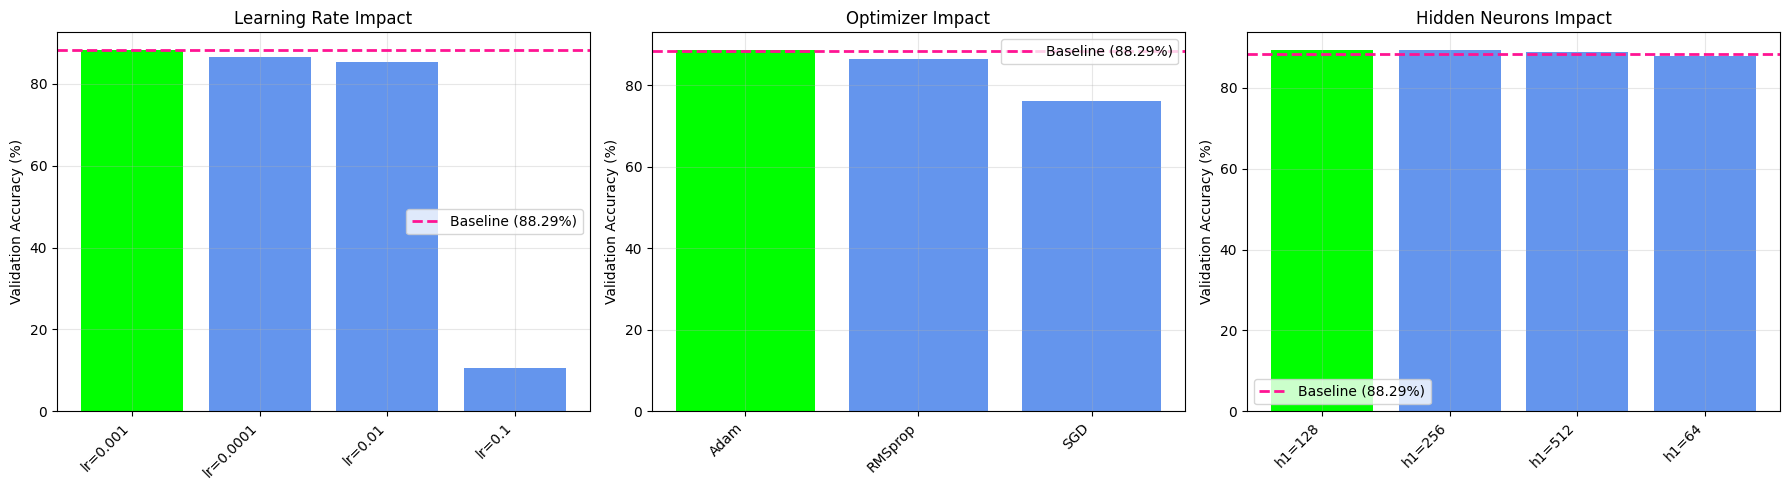

In [12]:

# Hyperparameter impact bar chart

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
experiments = ['Learning Rate', 'Optimizer', 'Hidden Neurons']

for idx, exp_name in enumerate(experiments):
    exp_data = results_df[results_df['experiment'] == exp_name]
    
    axes[idx].bar(range(len(exp_data)), exp_data['final_accuracy'], 
                  color=['lime' if acc == exp_data['final_accuracy'].max() 
                         else 'cornflowerblue' for acc in exp_data['final_accuracy']])
    axes[idx].axhline(y=baseline_accuracy, color='deeppink', linestyle='--', 
                      label=f'Baseline ({baseline_accuracy:.2f}%)', linewidth=2)
    axes[idx].set_xticks(range(len(exp_data)))
    axes[idx].set_xticklabels(exp_data['hyperparameter'], rotation=45, ha='right')
    axes[idx].set_ylabel('Validation Accuracy (%)')
    axes[idx].set_title(f'{exp_name} Impact')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

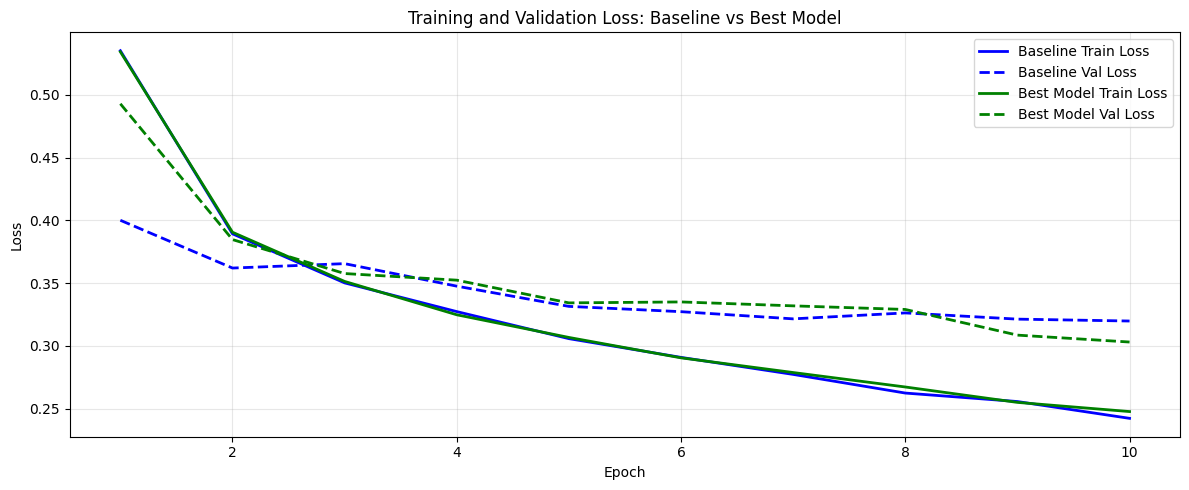

In [13]:

# Loss curves 

plt.figure(figsize=(12, 5))
epochs_range_baseline = range(1, len(baseline_results['train_losses']) + 1)
plt.plot(epochs_range_baseline, baseline_results['train_losses'], 
         'b-', label='Baseline Train Loss', linewidth=2)
plt.plot(epochs_range_baseline, baseline_results['val_losses'], 
         'b--', label='Baseline Val Loss', linewidth=2)

# Plot best model
epochs_range_best = range(1, len(best_model_results['train_losses']) + 1)
plt.plot(epochs_range_best, best_model_results['train_losses'], 
         'g-', label='Best Model Train Loss', linewidth=2)
plt.plot(epochs_range_best, best_model_results['val_losses'], 
         'g--', label='Best Model Val Loss', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss: Baseline vs Best Model')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


<Figure size 1000x800 with 0 Axes>

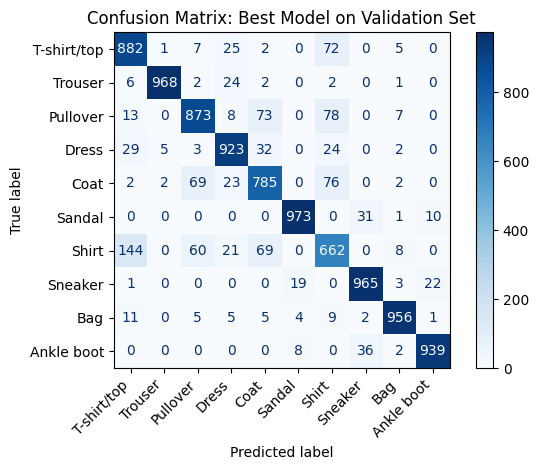


 All visualizations generated successfully!


In [14]:
# Confusion Matrix

best_model = best_model_results['model']
best_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in validation_loader:
        pred = best_model(X)
        all_preds.extend(pred.argmax(1).cpu().numpy())
        all_labels.extend(y.cpu().numpy())

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix: Best Model on Validation Set')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n All visualizations generated successfully!")